# Problem 2

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn

In [ ]:
!pip install tensorflow==2.13.0

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

## Dataset Import

In [3]:
import h5py
with h5py.File('train_happy.h5', 'r') as f:
    X_train = np.array(f["train_set_x"][:])
    y_train = np.array(f["train_set_y"][:])
    list_classes = np.array(f["list_classes"][:])

with h5py.File('test_happy.h5', 'r') as f:
    X_test = np.array(f["test_set_x"][:])
    y_test = np.array(f["test_set_y"][:])
    list_classes = np.array(f["list_classes"][:])

In [4]:
X_train.shape, y_train.shape

((600, 64, 64, 3), (600,))

In [5]:
X_test.shape, y_test.shape

((150, 64, 64, 3), (150,))

In [6]:
list_classes.shape

(2,)

## Dataset analysis and visualization

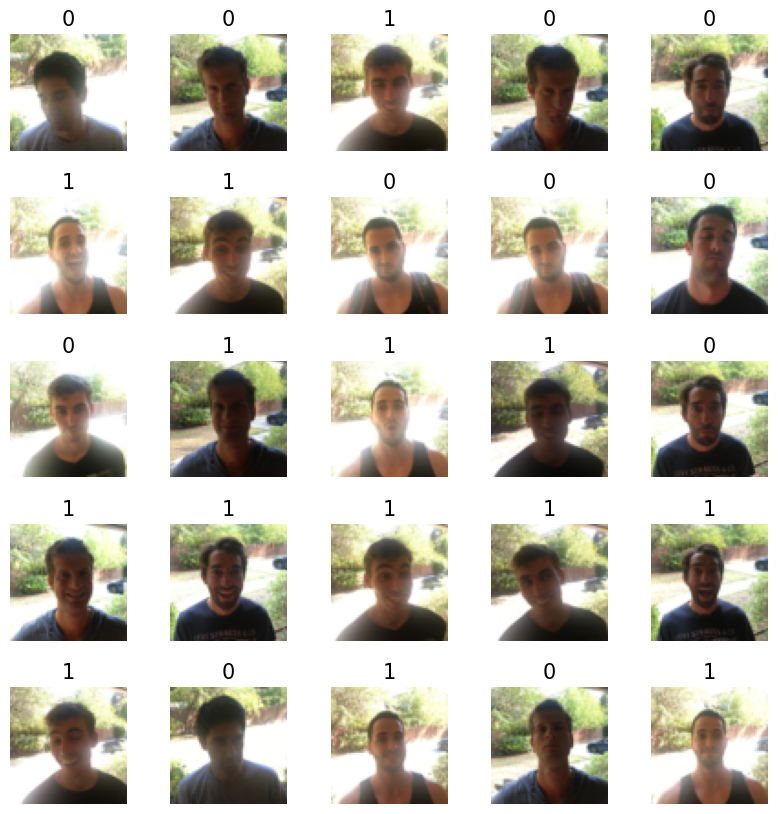

In [7]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow( X_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)        

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
print("Number of smiling and non-smiling images in training set")
print(dict(zip(unique, counts)))

Number of smiling and non-smiling images in training set
{0: 300, 1: 300}


In [9]:
unique, counts = np.unique(y_test, return_counts=True)
print("Number of smiling and non-smiling images in testing set")
print(dict(zip(unique, counts)))

Number of smiling and non-smiling images in testing set
{0: 66, 1: 84}


## Normalization

In [10]:
X_train_norm = (X_train)/255
X_test_norm = (X_test)/255

## Shuffle training set 

In [11]:
from sklearn.utils import shuffle
X_train_norm, y_train = shuffle(X_train_norm, y_train)

## Validation set

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train_norm_sp, X_val_sp, y_train_sp, y_val_sp = train_test_split(X_train_norm, y_train, test_size=0.2, shuffle=True, stratify=y_train)

## Model analysis

In [14]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
def test_architecture(model, batch_size, epochs, early_stopping=False, es_patience=5):
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=es_patience)

    # train model
    history = model.fit(X_train_norm_sp,
                 y_train_sp, 
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 1,
                 callbacks=[early_stopping_callback] if early_stopping else None,
                 validation_data = (X_val_sp, y_val_sp)
                 )

    # evaluate overall accuracy of the model
    score = model.evaluate(X_test_norm, y_test)
    print('Test Accuracy: {}'.format(score[1]))

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    # plot accuracy over epochs
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # plot loss over epochs
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    predict_x=model.predict(X_test_norm)
    predicted_classes = (predict_x > 0.5).astype(int).flatten() # argmax equivalent for binary classification
    y_true = y_test

    # create confusion matrix
    cm = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize = (5, 5))
    sns.heatmap(cm, annot = True)

    # compute metrics per class
    precisions, recall, f1_score, _ = precision_recall_fscore_support(y_true, predicted_classes)
    model_metrics_df = pd.DataFrame({
        'Class': [0,1],
        'Precision': precisions,
        'Recall': recall,
        'F1-Score': f1_score
    })


    print(model_metrics_df)

## Model architecture - Initial Version

In [30]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers

In [44]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(32, (5,5), activation = 'relu', input_shape = (64,64,3)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Conv2D(64, (5,5), activation = 'relu'))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))

CNN.add(layers.Dense(84, activation = 'relu'))

CNN.add(layers.Dense(1, activation = 'sigmoid'))
CNN.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 average_pooling2d_18 (Aver  (None, 30, 30, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 average_pooling2d_19 (Aver  (None, 13, 13, 64)        0         
 agePooling2D)                                                   
                                                                 
 flatten_9 (Flatten)         (None, 10816)             0         
                                                                 
 dense_27 (Dense)            (None, 120)             

Epoch 1/20
15/15 [==============================] - 6s 340ms/step - loss: 0.6801 - accuracy: 0.6021 - val_loss: 0.6039 - val_accuracy: 0.7750
Epoch 2/20
15/15 [==============================] - 4s 272ms/step - loss: 0.6176 - accuracy: 0.6333 - val_loss: 0.5997 - val_accuracy: 0.6583
Epoch 3/20
15/15 [==============================] - 4s 283ms/step - loss: 0.5227 - accuracy: 0.7708 - val_loss: 0.4748 - val_accuracy: 0.8000
Epoch 4/20
15/15 [==============================] - 4s 281ms/step - loss: 0.3529 - accuracy: 0.8375 - val_loss: 0.3853 - val_accuracy: 0.8000
Epoch 5/20
15/15 [==============================] - 4s 290ms/step - loss: 0.2954 - accuracy: 0.8854 - val_loss: 0.2560 - val_accuracy: 0.9167
Epoch 6/20
15/15 [==============================] - 4s 269ms/step - loss: 0.1989 - accuracy: 0.9146 - val_loss: 0.2402 - val_accuracy: 0.9167
Epoch 7/20
15/15 [==============================] - 4s 273ms/step - loss: 0.1422 - accuracy: 0.9458 - val_loss: 0.2435 - val_accuracy: 0.9333
Epoch 

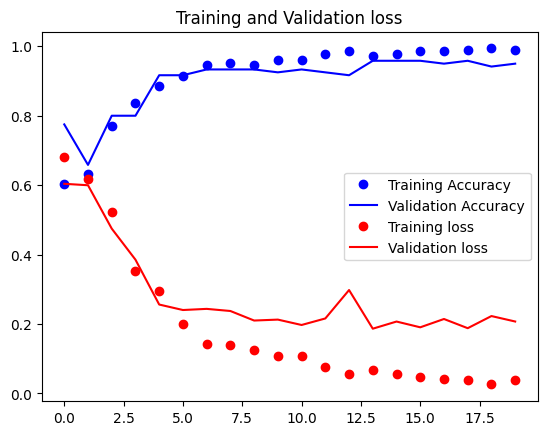

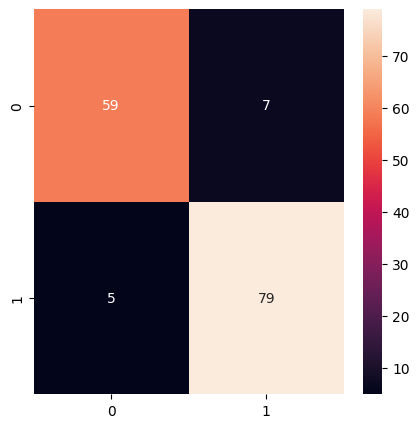

In [45]:
test_architecture(CNN, batch_size=32, epochs=20)

## Model architecture - 2nd Version

In [46]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(32, (5,5), activation = 'relu', input_shape = (64,64,3), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(64, (5,5), activation = 'relu', kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))

CNN.add(layers.Dense(84, activation = 'relu'))

CNN.add(layers.Dense(1, activation = 'sigmoid'))
CNN.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 average_pooling2d_20 (Aver  (None, 30, 30, 32)        0         
 agePooling2D)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 average_pooling2d_21 (Aver  (None, 13, 13, 64)        0         
 agePooling2D)                                                   
                                                                 
 flatten_10 (Flatten)        (None, 10816)           

Epoch 1/20
15/15 [==============================] - 7s 324ms/step - loss: 0.7126 - accuracy: 0.5437 - val_loss: 0.6703 - val_accuracy: 0.7667
Epoch 2/20
15/15 [==============================] - 4s 302ms/step - loss: 0.6371 - accuracy: 0.6438 - val_loss: 0.7534 - val_accuracy: 0.5167
Epoch 3/20
15/15 [==============================] - 5s 305ms/step - loss: 0.6582 - accuracy: 0.6250 - val_loss: 0.5698 - val_accuracy: 0.7750
Epoch 4/20
15/15 [==============================] - 4s 295ms/step - loss: 0.5196 - accuracy: 0.7479 - val_loss: 0.5236 - val_accuracy: 0.7750
Epoch 5/20
15/15 [==============================] - 4s 295ms/step - loss: 0.4862 - accuracy: 0.7792 - val_loss: 0.3608 - val_accuracy: 0.8750
Epoch 6/20
15/15 [==============================] - 4s 292ms/step - loss: 0.3015 - accuracy: 0.8875 - val_loss: 0.3507 - val_accuracy: 0.8333
Epoch 7/20
15/15 [==============================] - 4s 300ms/step - loss: 0.2868 - accuracy: 0.8687 - val_loss: 0.2953 - val_accuracy: 0.8667
Epoch 

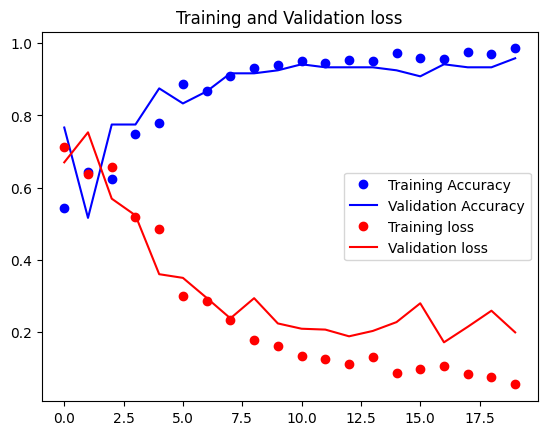

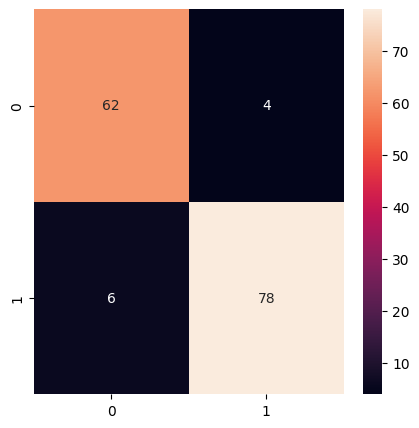

In [47]:
test_architecture(CNN, batch_size=32, epochs=20)

## Model architecture - 3rd Version

In [54]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(32, (5,5), activation = layers.LeakyReLU(alpha=0.1), input_shape = (64,64,3), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(64, (5,5), activation = layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.L2(1e-4)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))

CNN.add(layers.Dense(84, activation = 'relu'))

CNN.add(layers.Dense(1, activation = 'sigmoid'))
CNN.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 average_pooling2d_28 (Aver  (None, 30, 30, 32)        0         
 agePooling2D)                                                   
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 average_pooling2d_29 (Aver  (None, 13, 13, 64)        0         
 agePooling2D)                                                   
                                                                 
 flatten_14 (Flatten)        (None, 10816)           

Epoch 1/20
15/15 [==============================] - 6s 290ms/step - loss: 0.7248 - accuracy: 0.5479 - val_loss: 0.6493 - val_accuracy: 0.5917
Epoch 2/20
15/15 [==============================] - 4s 275ms/step - loss: 0.6256 - accuracy: 0.6479 - val_loss: 0.5743 - val_accuracy: 0.6167
Epoch 3/20
15/15 [==============================] - 4s 282ms/step - loss: 0.5833 - accuracy: 0.6792 - val_loss: 0.4805 - val_accuracy: 0.8083
Epoch 4/20
15/15 [==============================] - 4s 277ms/step - loss: 0.4440 - accuracy: 0.7937 - val_loss: 0.3275 - val_accuracy: 0.8417
Epoch 5/20
15/15 [==============================] - 4s 273ms/step - loss: 0.2912 - accuracy: 0.8729 - val_loss: 0.2575 - val_accuracy: 0.9417
Epoch 6/20
15/15 [==============================] - 4s 268ms/step - loss: 0.2323 - accuracy: 0.9062 - val_loss: 0.2557 - val_accuracy: 0.9167
Epoch 7/20
15/15 [==============================] - 4s 283ms/step - loss: 0.2443 - accuracy: 0.9187 - val_loss: 0.2312 - val_accuracy: 0.9333
Epoch 

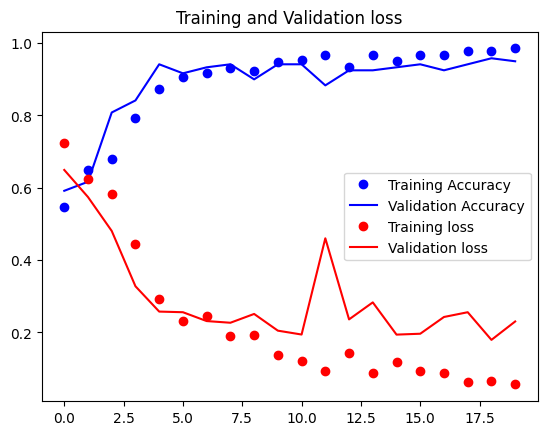

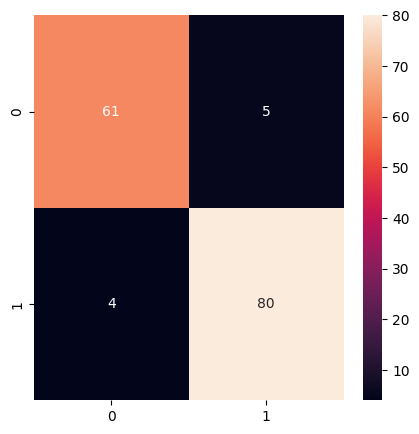

In [55]:
test_architecture(CNN, batch_size=32, epochs=20)